# <span style="color:Maroon">ПРОЕКТ: Оптимизация производственных расходов</span>

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.<br><br>    
<b>Цель данного проекта</b> - Необходимо построить модель, которая предскажет температуру стали<br><br>    
Заказчику важны:<br>
<li>Модель со значением метрики качества <b>MAE</b> не более <b>8.7</b>.<br><br>    
<span style="color:Maroon"><b>1 Загрузить и подготовить данные:</b></span><br><br>
<li>Проверить состав предоставленной выбороки;
<li>Проанализировать данные;
<li>Провести предобработку данных;
<li>Описать результаты.<br><br>
<span style="color:Maroon"><b>2 Обучить модель и выбрать лучшую:</b></span><br><br>
<li>Обучите разные модели на базовых настройках;
<li>Обучите разные модели на с подбором гиперпараметров;
<li>Подобрать для моделей оптимальные гиперпараметры;
<li>Оценить качество моделей кросс-валидацией;
<li>Выбрать лучшую модель
<li>Сделать выводы.<br><br>
<span style="color:Maroon"><b>3 Тестирование лучшей модели:</b></span><br><br>
<li>Проверить модель на тестовой выборке;
<li>Проанализировать предсказания выбранной модели;
<li>Написать выводы и обосновать выбор.
 </div>

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
создам стиль для отображения табличных данных
</div>

In [1]:
cell_hover     = {'selector': 'td:hover',
                  'props'   : [('background', '#9E4447'), 
                               ('color', '#ffffff')]}           # формат выделенной ячейки

row_hover      = {'selector': 'tr:hover',
                  'props'   : [('background', '#808080'), 
                               ('color', '#ffffff')]}           # формат выделенной строки

color_row_even = {'selector': 'tr:nth-of-type(even)',
                  'props'   : [('background', '#D9D9D9'),
                               ('color', 'black')]}             # формат нечетных строк

color_row_odd  = {'selector': 'tr:nth-of-type(odd)',
                  'props'   : [('background', '#ffffff'),
                               ('color', '#363636')]}           # формат четных строк

index_names    = {'selector': 'th',
                  'props'   : [('background', '#363636'), 
                               ('color', '#ffffff'),  
                               ('text-align','center')]}        # формат заголовка и индекса

border_inner   = {'selector': 'td',
                  'props'   : [('border','1px dashed #363636')]}# формат границы таблицы

border_outer   = {'selector': '',
                  'props'   : [('border','2px solid #363636')]} # формат границы таблицы

caption        = {'selector': 'caption',
                  'props'   : [('color', '#363636'), 
                               ('font-size', '15px')]}

# передаю в переменную для дальнейшего использования
styler = [cell_hover, color_row_even, color_row_odd, index_names, row_hover, border_inner, border_outer, caption]

## Загрузка и подготовка данных

In [2]:
# библиотеки
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings 
from matplotlib import pyplot as plt
from time import time

# обработка
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# модели
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

# метрики
from sklearn.metrics import mean_absolute_error

# настройки и параметры
from tqdm import notebook
RANDOM     = 1123581321
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
data_arc       = pd.read_csv('data_arc.csv')
data_bulk      = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas       = pd.read_csv('data_gas.csv')
data_temp      = pd.read_csv('data_temp.csv')
data_wire      = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

In [4]:
data_flow      = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]
data_flow_name = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Посмотрим на качество предоставленных данных
</div>

In [5]:
for name, data in enumerate(data_flow):
    print(f'Набор данных {data_flow_name[name]}')
    print()
    display(data.info())
    print('='*100)

Набор данных data_arc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Набор данных data_bulk

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Набор данных data_bulk_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Набор данных data_gas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Набор данных data_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

Набор данных data_wire

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Набор данных data_wire_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
После первого осмотра данных выявлены следующие замечания:<br>
<li>основной датасет <b>data_temp</b>, в нем находится информация по температуре на момент завершения технологического процесса плавки металла, последняя запись о замере температуры в партии является целевым признаком. Соответственно построение финального датасета будет ориентированно именно на этот набор данных;
<li>В датасете <b>data_temp</b> есть большое количество пропусков относительно общего набора данных, восстанавливать эти данные нет смысла и может только навредить моделированию, т.к. целевой ориентир может быть искажен;
<li>Общие замечание по наборам данных: наличие большого количества пропусков в данных, название столбцов не в "питонском формате", тип данных <b><i>object</i></b> где информация о времени, необходимо изменить тип.
<li>Далее пройдемся по каждому набору данных более детально, но предварительно сразу изменю название столбцов и поменяю тип данных.
</div>

In [6]:
data_arc.columns  = ['key', 'time_start_heat', 'time_end_heat', 'active_pwr', 'reactive_pwr']
data_gas.columns  = ['key', 'gas']
data_temp.columns = ['key', 'time_measure', 'temperature']

In [7]:
# функция для изменения формата даты
def object_to_date(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            data[column] = pd.to_datetime(data[column], format="%Y-%m-%d %H:%M:%S")
    return data

In [8]:
# функция для переименования столбцов в "питонский формат"
def columns_rename(data):
    columns_new = []
    for column in data.columns:
        columns_new.append(column.replace(' ', '_').lower())
    data.columns = columns_new
    return data

In [9]:
for data in data_flow:
    columns_rename(data)
    object_to_date(data)  

In [10]:
for name, data in enumerate(data_flow):
    display(data.head(10).style\
                         .set_caption(f'Набор данных {data_flow_name[name]}')\
                         .set_table_styles(styler))
    display(data.info())
    print('='*100)

,key,time_start_heat,time_end_heat,active_pwr,reactive_pwr
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              14876 non-null  int64         
 1   time_start_heat  14876 non-null  datetime64[ns]
 2   time_end_heat    14876 non-null  datetime64[ns]
 3   active_pwr       14876 non-null  float64       
 4   reactive_pwr     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,nan,nan,nan,43.000000,nan,nan,nan,nan,nan,nan,nan,206.000000,nan,150.000000,154.000000
1,2,nan,nan,nan,73.000000,nan,nan,nan,nan,nan,nan,nan,206.000000,nan,149.000000,154.000000
2,3,nan,nan,nan,34.000000,nan,nan,nan,nan,nan,nan,nan,205.000000,nan,152.000000,153.000000
3,4,nan,nan,nan,81.000000,nan,nan,nan,nan,nan,nan,nan,207.000000,nan,153.000000,154.000000
4,5,nan,nan,nan,78.000000,nan,nan,nan,nan,nan,nan,nan,203.000000,nan,151.000000,152.000000
5,6,nan,nan,nan,117.000000,nan,nan,nan,nan,nan,nan,nan,204.000000,nan,201.000000,154.000000
6,7,nan,nan,nan,117.000000,nan,nan,nan,nan,nan,nan,nan,204.000000,nan,152.000000,154.000000
7,8,nan,nan,nan,99.000000,nan,nan,nan,nan,nan,nan,nan,410.000000,nan,252.000000,153.000000
8,9,nan,nan,nan,117.000000,nan,nan,nan,nan,nan,nan,nan,107.000000,nan,99.000000,203.000000
9,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,203.000000,nan,102.000000,204.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaT,NaT,NaT,2019-05-03 13:59:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:53:27,NaT,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaT,NaT,NaT,2019-05-03 14:29:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:22:19,NaT,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaT,NaT,NaT,2019-05-03 15:04:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:55:46,NaT,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaT,NaT,NaT,2019-05-03 15:47:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:41:00,NaT,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:18:52,NaT,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,time_measure,temperature
0,1,2019-05-03 11:16:18,1571.000000
1,1,2019-05-03 11:25:53,1604.000000
2,1,2019-05-03 11:29:11,1618.000000
3,1,2019-05-03 11:30:01,1601.000000
4,1,2019-05-03 11:30:39,1613.000000
5,2,2019-05-03 11:37:27,1581.000000
6,2,2019-05-03 11:38:00,1577.000000
7,2,2019-05-03 11:49:38,1589.000000
8,2,2019-05-03 11:55:50,1604.000000
9,2,2019-05-03 11:58:24,1608.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   time_measure  15907 non-null  datetime64[ns]
 2   temperature   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,nan,nan,nan,nan,nan,nan,nan,nan
1,2,96.052315,nan,nan,nan,nan,nan,nan,nan,nan
2,3,91.160157,nan,nan,nan,nan,nan,nan,nan,nan
3,4,89.063515,nan,nan,nan,nan,nan,nan,nan,nan
4,5,89.238236,9.114560,nan,nan,nan,nan,nan,nan,nan
5,6,99.109917,9.114560,nan,nan,nan,nan,nan,nan,nan
6,7,98.061600,nan,nan,nan,nan,nan,nan,nan,nan
7,8,155.282394,nan,nan,nan,nan,nan,nan,nan,nan
8,9,113.393279,9.143681,nan,nan,nan,nan,nan,nan,nan
9,10,81.244796,12.376000,nan,nan,nan,nan,nan,nan,nan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:28:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:03:42,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Первые изменения внесены, теперь необходимо познакомиться с составом информации по партиям в каждом наборе данных, чтобы понять насколько большие различия в них, т.к. некоторые таблицы содержат уже агрегированные данные для каждой партии, а некоторые несут дополнительную информацию по итерациям нагрева, необходимо понять сколько всего уникальных партий
</div>

In [11]:
for name, data in enumerate(data_flow):
    print(f'Количество партий {len(data["key"].unique())} в наборе данных {data_flow_name[name]}')

Количество партий 3214 в наборе данных data_arc
Количество партий 3129 в наборе данных data_bulk
Количество партий 3129 в наборе данных data_bulk_time
Количество партий 3239 в наборе данных data_gas
Количество партий 3216 в наборе данных data_temp
Количество партий 3081 в наборе данных data_wire
Количество партий 3081 в наборе данных data_wire_time


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Как видно из информации выше, в каждом датасете имеется разное количество партий, за исключение только информации о материалах, но это очевидно т.к. они сильно зависимы. Это очень странная ситуация, которая говорит о том, что выгрузка была произведена скорее всего не верно, качество предоставленных данных оставляет желать лучшего. Здесь бы я, наверное, обратился к тому, кто выгружал их, но за неимением такой возможности продолжим работать с тем что есть.
</div>

## Анализ данных

### Анализ данных по замерам температуры

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Первый датасет для анализа выбран не случайно, как я говорил выше это основной набор информации, на котором будет строится аналитика. В этом датасете мне необходимо получить информацию для каждой партии о первом замере температуры и последнем, для этого промаркирую набор данных
</div>

In [12]:
target = data_temp.copy()

In [13]:
target.loc[target.sort_values("time_measure").
       groupby("key").
       apply(lambda x: x.index[0]), "mark"] = 'first'

In [14]:
target.loc[target.sort_values("time_measure", ascending = False).
       groupby("key").
       apply(lambda x: x.index[0]), "mark"] = 'last'

In [15]:
target.head().style.format({'temperature':'{:.0f}'}).set_table_styles(styler)

,key,time_measure,temperature,mark
0,1,2019-05-03 11:16:18,1571,first
1,1,2019-05-03 11:25:53,1604,nan
2,1,2019-05-03 11:29:11,1618,nan
3,1,2019-05-03 11:30:01,1601,nan
4,1,2019-05-03 11:30:39,1613,last


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Необходимые данные помечены, посмотрим на соотношение информации и проверим есть ли пары для каждой записи
</div>

In [16]:
target.query('mark == "last"').shape[0], target.query('mark == "first"').shape[0]

(3216, 3214)

In [17]:
data_temp.value_counts('key').sort_values(ascending = True).head()

key
279     1
195     1
982     2
3093    2
1106    2
dtype: int64

In [18]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   time_measure  15907 non-null  datetime64[ns]
 2   temperature   13006 non-null  float64       
 3   mark          6430 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 497.2+ KB


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Как можно заметить есть две партии для которых существует только одна запись с замером температуры, возможно это правда, но у меня большие сомнения по поводу этой ситуации, поэтому мне придется удалить эти партии, считаю их не корректными. Так же после объединения данных избавлюсь от пропусков
</div>

In [19]:
target = target.query('mark == "last"')[['key', 'time_measure', 'temperature']]\
               .merge(target.query('mark == "first"')[['key', 'time_measure', 'temperature']],
                      on = 'key', 
                      how = 'left',
                      suffixes = ("_finish", "_start"))\
               .rename(columns = {'time_measure_finish' : 'time_finish_measure', 'time_measure_start' : 'time_start_measure'})

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Очистим оставшиеся данные от возможных пропусков и также проведем проверку датасета на предмет наличия данных в которых начальная температура равна финальной, и удалим эти данные из за возможной утечки признака
</div>

In [20]:
target = target.dropna()
target = target.query('temperature_start !=  temperature_finish')

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Посмотрим на распределение данных, возможно обнаружим аномалии или выбросы
</div>

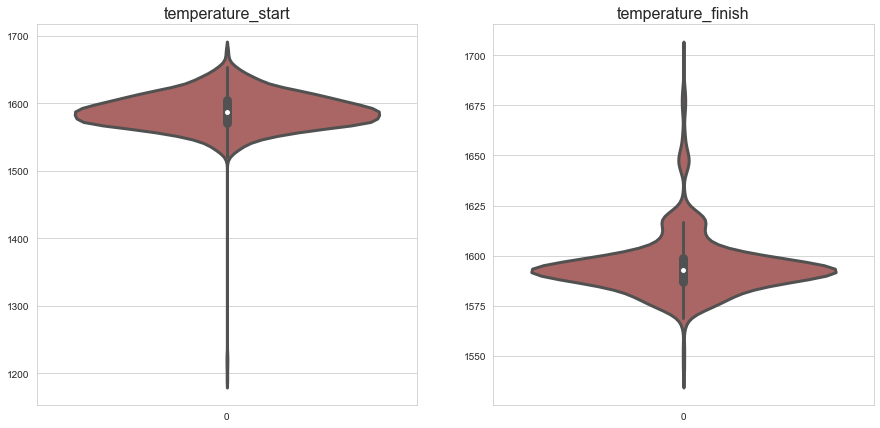

In [21]:
plt.figure(figsize = (15, 7))
sns.set_style('whitegrid')
x = ['temperature_start', 'temperature_finish']

for i, temp in enumerate(x):
    
    plt.subplot(1, 2, i + 1)
    plt.title(x[i], fontsize=16)
    sns.set_style('whitegrid')
    sns.violinplot(data = target[temp],
                   color      = '#c0504d',
                   saturation = 0.6,
                   linewidth  = 3,
                   edgecolor  = '#363636')
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Как видно из графиков распределение не равномерное есть некоторые аномалии особенно что касается температуры старта, необходимо посмотреть если количество небольшое, можно принять за нижний уровень температуру 1500. С показателями температуры финиша, все сложнее особенно в ее верхней части, где после небольшого провала появляются данные. Если ориентироваться на данные по начальной температуре, то диапазон выглядит корректным, попробую оставить значения без изменений.
</div>

In [22]:
target.query('temperature_start < 1500')\
      .style\
      .format({'temperature_finish':'{:.0f}', 'temperature_start':'{:.0f}'})\
      .set_table_styles(styler)

,key,time_finish_measure,temperature_finish,time_start_measure,temperature_start
855,867,2019-06-04 14:57:17,1599,2019-06-04 14:21:00,1191
1201,1214,2019-06-16 06:14:45,1591,2019-06-16 05:32:00,1208
1604,1619,2019-06-30 11:21:54,1590,2019-06-30 11:03:54,1218
2036,2052,2019-07-21 15:24:06,1592,2019-07-21 14:51:40,1227


In [23]:
target = target.query('temperature_start > 1500')

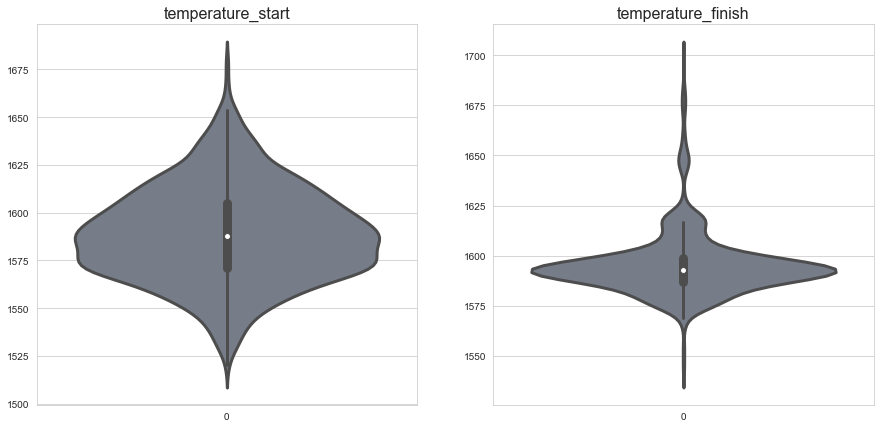

In [24]:
plt.figure(figsize = (15, 7))
sns.set_style('whitegrid')
x = ['temperature_start', 'temperature_finish']

for i, temp in enumerate(x):
    
    plt.subplot(1, 2, i + 1)
    plt.title(x[i], fontsize=16)
    sns.set_style('whitegrid')
    sns.violinplot(data = target[temp],
                   palette    = 'bone',
                   saturation = 0.6,
                   linewidth  = 3,
                   edgecolor  = '#363636')
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Теперь набор данных выглядит нормально распределенным, конечно сильное искажение в данных по температуре последнего замера, но я оставлю его как есть. Посмотрим на объем утерянных данных
</div>

In [25]:
target.shape[0], len(data_temp["key"].unique())

(2429, 3216)

In [26]:
'{:.0%}'.format(1 - target.shape[0] / len(data_temp["key"].unique()))

'24%'

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Серьёзные изменения в 24% от первоначального состава, я бы вернул эти данные на доработку или проверку выгрузки
</div>

In [27]:
target.head().style.format({'temperature_finish':'{:.0f}', 'temperature_start':'{:.0f}'}).set_table_styles(styler)

,key,time_finish_measure,temperature_finish,time_start_measure,temperature_start
0,1,2019-05-03 11:30:39,1613,2019-05-03 11:16:18,1571
1,2,2019-05-03 11:59:12,1602,2019-05-03 11:37:27,1581
2,3,2019-05-03 12:34:57,1599,2019-05-03 12:13:17,1596
3,4,2019-05-03 12:59:25,1625,2019-05-03 12:52:57,1601
4,5,2019-05-03 13:36:01,1602,2019-05-03 13:23:19,1576


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Базовый набор данных определен, 2429 записей, т.е. партий на начальном этапе, данные по времени и начальной температуре сохранены для дальнейшего использования на стадии определения признаков и проверки корректности данных
</div>

### Анализ данных сыпучих материалов

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Далее проверим данные по материалам из наборов <b>data_bulk</b> и <b>data_bulk_time</b>. Как и на предыдущем шаге, здесь необходимо получить информацию по начальному и конечному времени засыпки материалов в ковш, для этого построчно проверю и найду максимальное и минимальное значение времени. Большое количество пропусков связано с тем, что не во всех партиях используется материалы некоторых видов, поэтому заполнять пропуски я буду заглушкой из 0. Проверю так же чтобы не было записей совсем пустых
</div>

In [28]:
bulk_time = data_bulk_time.copy()

In [29]:
bulk_time = bulk_time.assign(time_start_bulk  = (bulk_time.loc[:, 'bulk_1':'bulk_15']).min(axis = 1),
                             time_finish_bulk = (bulk_time.loc[:, 'bulk_1':'bulk_15']).max(axis = 1))

In [30]:
(data_bulk.loc[:, 'bulk_1':'bulk_15']).sum(axis = 1).isna().sum()

0

In [31]:
bulk_time.head().style.set_table_styles(styler)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_start_bulk,time_finish_bulk
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:21:30
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:38
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:31:06
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:43
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:50


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Информация добавлена, так же проверены пустые строки - таких нет. Посмотрим на распределение каждого материала
</div>

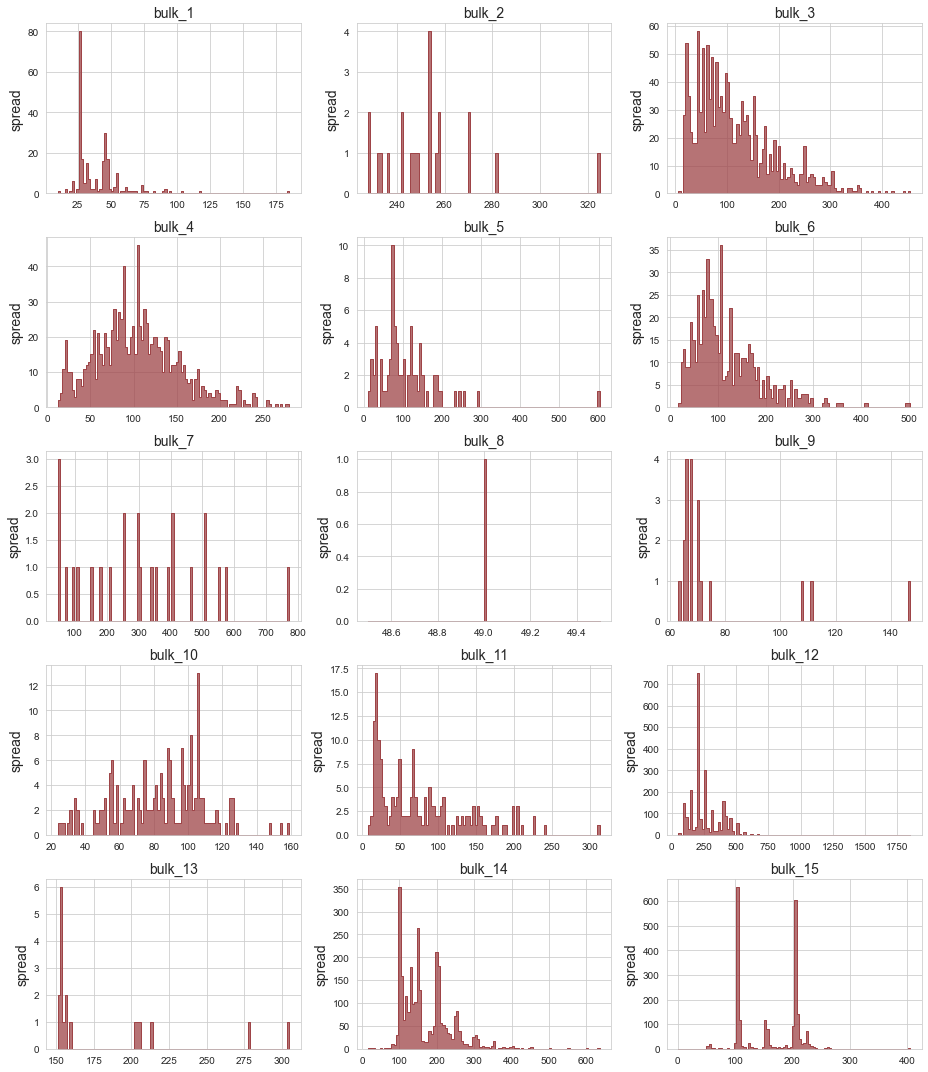

In [32]:
plt.figure(figsize = (13, 15))
sns.set_style('whitegrid')
x = list(data_bulk.columns[1:])

for i, bulk in enumerate(x):
    
    plt.subplot(5, 3, i + 1)
    sns.histplot(data = data_bulk[bulk],
                 color = '#9E4447',
                 element="step",
                 bins = 100)
    
    plt.title(f'{x[i]}', fontsize = 14)
    plt.ylabel('spread', fontsize = 14)
    plt.xlabel('')
    plt.tight_layout()    
plt.show()

In [33]:
for i in list(data_bulk.columns[1:]):
    print(f'записей в признаке {i} = {data_bulk[i].count()}')

записей в признаке bulk_1 = 252
записей в признаке bulk_2 = 22
записей в признаке bulk_3 = 1298
записей в признаке bulk_4 = 1014
записей в признаке bulk_5 = 77
записей в признаке bulk_6 = 576
записей в признаке bulk_7 = 25
записей в признаке bulk_8 = 1
записей в признаке bulk_9 = 19
записей в признаке bulk_10 = 176
записей в признаке bulk_11 = 177
записей в признаке bulk_12 = 2450
записей в признаке bulk_13 = 18
записей в признаке bulk_14 = 2806
записей в признаке bulk_15 = 2248


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Данные очень сильно неравномерны, сильный дисбаланс в классах, некоторые признаки имею только одну запись <b>bulk_8</b>, что возможно на финальном этапе необходимо будет удалить те признаки, у которых менее 100 записей т.к. никакого влияния не будет нести, очень мало данных и сильный разброс, что опять говорить о низком качестве предоставленной информации
</div>

### Анализ данных проволочных материалов

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Далее проверим данные по материалам из наборов <b>data_wire</b> и <b>data_wire_time</b>. Как и на предыдущем шаге, здесь необходимо получить информацию по начальному и конечному времени засыпки материалов в ковш, для этого построчно проверю и найду максимальное и минимальное значение времени. Большое количество пропусков связано с тем, что не во всех партиях используется материалы некоторых видов, поэтому заполнять пропуски я буду заглушкой из 0. Проверю так же чтобы не было записей совсем пустых
</div>

In [34]:
wire_time = data_wire_time.copy()

In [35]:
wire_time = wire_time.assign(time_start_wire  = (wire_time.loc[:, 'wire_1':'wire_9']).min(axis = 1),
                             time_finish_wire = (wire_time.loc[:, 'wire_1':'wire_9']).max(axis = 1))

In [36]:
(data_wire.loc[:, 'wire_1':'wire_9']).sum(axis = 1).isna().sum()

0

In [37]:
wire_time.head().style.set_table_styles(styler)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,time_start_wire,time_finish_wire
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:11:41,2019-05-03 11:11:41
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:46:10,2019-05-03 11:46:10
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:13:47,2019-05-03 12:13:47
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:48:05,2019-05-03 12:48:05
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:18:15,2019-05-03 13:32:06


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Информация добавлена, так же проверены пустые строки - таких нет. Посмотрим на распределение каждого материала
</div>

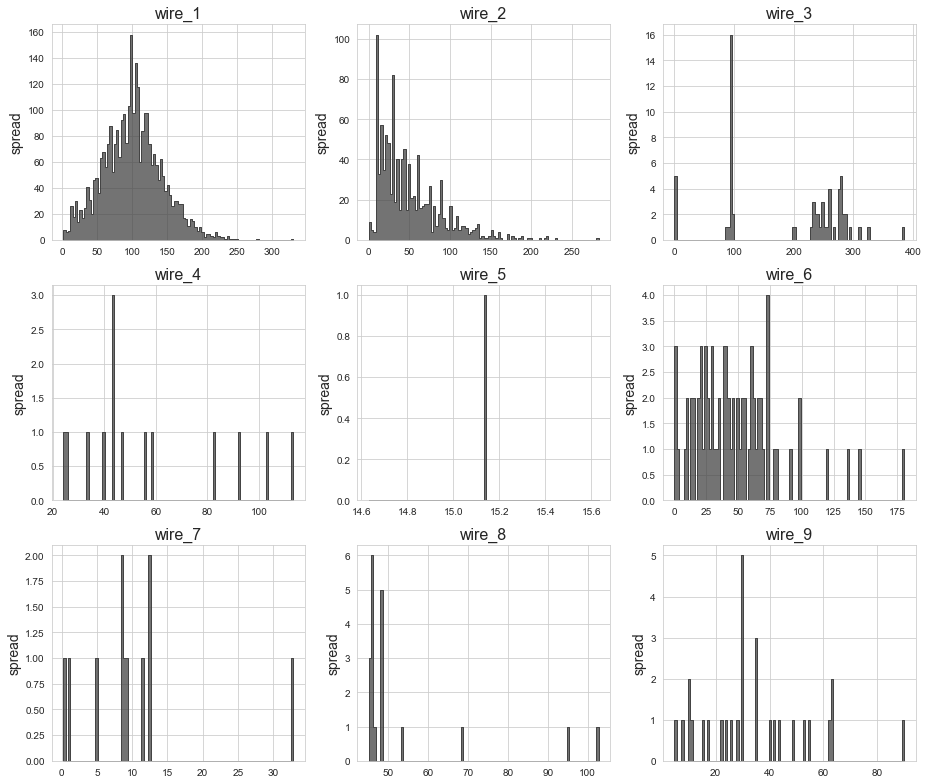

In [38]:
plt.figure(figsize = (13, 11))
sns.set_style('whitegrid')
x = list(data_wire.columns[1:])

for i, wire in enumerate(x):
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(data = data_wire[wire],
                 color = '#444444',
                 element="step",
                 bins = 100)
    
    plt.title(f'{x[i]}', fontsize = 16)
    plt.ylabel('spread', fontsize = 14)
    plt.xlabel('')
    plt.tight_layout()    
plt.show()

In [39]:
for i in list(data_wire.columns[1:]):
    print(f'записей в признаке {i} = {data_wire[i].count()}')

записей в признаке wire_1 = 3055
записей в признаке wire_2 = 1079
записей в признаке wire_3 = 63
записей в признаке wire_4 = 14
записей в признаке wire_5 = 1
записей в признаке wire_6 = 73
записей в признаке wire_7 = 11
записей в признаке wire_8 = 19
записей в признаке wire_9 = 29


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Данные очень сильно неравномерны, сильный дисбаланс в классах, некоторые признаки имею только одну запись <b>wire_5</b>, что возможно на финальном этапе необходимо будет удалить, т.к. 90% набора это всего лишь два признака, те признаки у которых менее 100 записей т.к. никакого влияния не будет нести, очень мало данных и сильный разброс, что опять говорить о низком качестве предоставленной информации
</div>

### Анализ данных электродов

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Данный датасет интересен тем, что в нем информация по технологическому процессу нагрева металла, где угазаны периоды нагрева, а также данные по затраченной энергии. Этот датасет очень важен для подготовки данных из него я возьму информацию о времени начала техпроцесса о времени его завершения, на основании этой информации я выведу новый показатель о продолжительности техпроцесса для каждой партии в агрегированном состоянии. Так же т.к. мы имеем информацию о активной и реактивной мощности, то я найду полную потраченную мощность по формуле и создам на основании нее новый показатель. Время мне поможет найти, если такие имеются данные которые противоречат технологическому процессу. Я буду сравнивать время засыпки материалов и замера температуры именно по этим данным чтобы точно отсечь аномалии
</div>

In [40]:
heat_data = data_arc.copy()

In [41]:
heat_data = heat_data.assign(total_time = heat_data['time_end_heat'] - heat_data['time_start_heat'])

In [42]:
heat_data['total_time'] = heat_data['total_time'].astype('timedelta64[s]')

In [43]:
heat_data['total_power'] = np.sqrt(np.power(heat_data['active_pwr'],2) + np.power(heat_data['reactive_pwr'],2))

In [44]:
heat_data.loc[heat_data.sort_values("time_start_heat").
       groupby("key").
       apply(lambda x: x.index[0]), "mark"] = 'first'

In [45]:
heat_data.loc[heat_data.sort_values("time_end_heat", ascending = False).
       groupby("key").
       apply(lambda x: x.index[0]), "mark"] = 'last'

In [46]:
heat_data.head().style.set_table_styles(styler)

,key,time_start_heat,time_end_heat,active_pwr,reactive_pwr,total_time,total_power,mark
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.000000,1.193639,first
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.000000,0.959010,nan
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.000000,0.896038,nan
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.000000,1.970470,nan
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.000000,0.807239,last


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Данные размечены, до того, как буду выводить агрегированные данные необходимо ознакомиться с распределением информации по мощности на предмет выбросов и аномалий
</div>

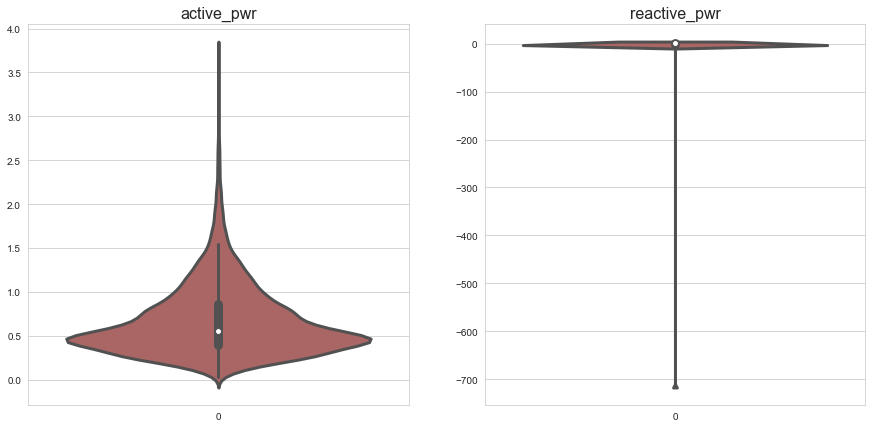

In [47]:
plt.figure(figsize = (15, 7))
sns.set_style('whitegrid')
x = ['active_pwr', 'reactive_pwr']

for i, power in enumerate(x):
    
    plt.subplot(1, 2, i + 1)
    plt.title(x[i], fontsize=16)
    sns.set_style('whitegrid')
    sns.violinplot(data = heat_data[power],
                   color      = '#c0504d',
                   saturation = 0.6,
                   linewidth  = 3,
                   edgecolor  = '#363636')
plt.show()

In [48]:
heat_data.describe().style.format('{:.2f}').set_table_styles(styler)

,key,active_pwr,reactive_pwr,total_time,total_power
count,14876.00,14876.00,14876.00,14876.00,14876.00
mean,1615.22,0.67,0.45,171.67,0.89
std,934.57,0.41,5.88,98.19,5.88
min,1.00,0.03,-715.50,11.00,0.04
25%,806.00,0.40,0.29,107.00,0.50
50%,1617.00,0.56,0.42,147.00,0.69
75%,2429.00,0.86,0.64,214.00,1.07
max,3241.00,3.73,2.68,907.00,715.51


In [49]:
heat_data.query('reactive_pwr < 0').style.set_table_styles(styler)

,key,time_start_heat,time_end_heat,active_pwr,reactive_pwr,total_time,total_power,mark
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109.000000,715.505096,nan


In [50]:
heat_data.query('active_pwr > 3').style.set_table_styles(styler)

,key,time_start_heat,time_end_heat,active_pwr,reactive_pwr,total_time,total_power,mark
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388,907.000000,4.592152,nan
9226,2001,2019-07-19 20:19:15,2019-07-19 20:31:16,3.156276,2.504206,721.000000,4.029036,nan
9870,2139,2019-07-24 17:01:13,2019-07-24 17:12:06,3.107820,1.946782,653.000000,3.667220,nan
12424,2701,2019-08-13 06:11:16,2019-08-13 06:25:02,3.150762,2.397032,826.000000,3.958922,nan
13277,2890,2019-08-20 06:19:59,2019-08-20 06:30:28,3.029744,1.946579,629.000000,3.601183,nan
14200,3086,2019-08-27 03:41:09,2019-08-27 03:53:10,3.052813,2.216230,721.000000,3.772445,nan


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Как видно из графика есть заметные выбросы или даже аномалии, так для реактивной мощности есть явно аномальное значение -715,5, его необходимо удалить. Для набора данных по активной мощности тоже есть выбросы со значение более 3, попробую их оставить возможно они не сильно повлияют на конечный результат
</div>

In [51]:
heat_data = heat_data.query('key != 2116')

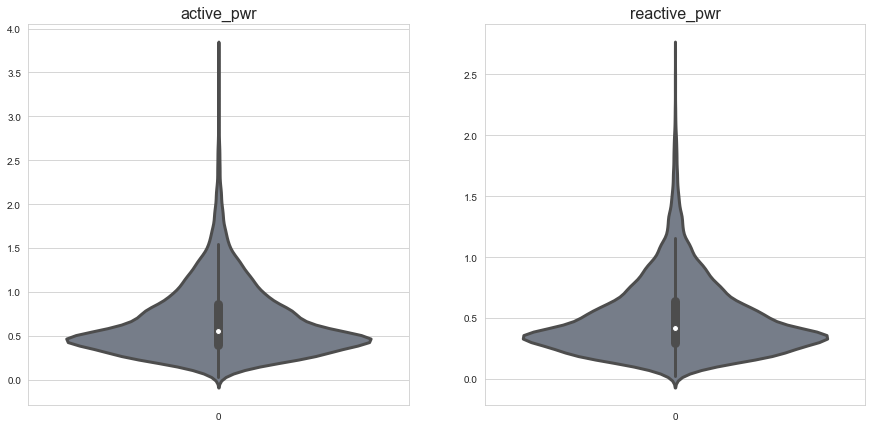

In [52]:
plt.figure(figsize = (15, 7))
sns.set_style('whitegrid')
x = ['active_pwr', 'reactive_pwr']

for i, power in enumerate(x):
    
    plt.subplot(1, 2, i + 1)
    plt.title(x[i], fontsize=16)
    sns.set_style('whitegrid')
    sns.violinplot(data = heat_data[power],
                   palette    = 'bone',
                   saturation = 0.6,
                   linewidth  = 3,
                   edgecolor  = '#363636')
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Теперь распределения выглядят симметрично
</div>

In [53]:
data_temp.value_counts('key').sort_values(ascending = True).head()

key
279     1
195     1
982     2
3093    2
1106    2
dtype: int64

In [54]:
heat_data.query('mark == "first"')[['key', 'time_start_heat']]\
         .merge(heat_data.query('mark == "last"')[['key', 'time_end_heat']],
                on = 'key', 
                how = 'outer').isna().sum()

key                 0
time_start_heat    39
time_end_heat       0
dtype: int64

In [55]:
heat_data.groupby('key')['total_time', 'total_power'].sum().isna().sum()

total_time     0
total_power    0
dtype: int64

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Проверил сколько пар отсутствует по времени для начала и финиша, всего две, также предварительно посмотрел сколько будет пропусков в результате объединения и из-за того, что данные с пропусками. Потери будут не критичными можно объединить данные
</div>

In [56]:
heat_data = heat_data.query('mark == "first"')[['key', 'time_start_heat']]\
                     .merge(heat_data.query('mark == "last"')[['key', 'time_end_heat']],
                            on = 'key', 
                            how = 'outer')\
                     .merge(heat_data.groupby('key')['total_time', 'total_power'].sum(),
                            on = 'key', 
                            how = 'outer')

In [57]:
heat_data.head()\
         .style\
         .set_caption(f'Набор данных для электродов')\
         .format({'total_time' : '{:.0f}', 'total_power' : '{:.2f}'})\
         .set_table_styles(styler)

,key,time_start_heat,time_end_heat,total_time,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.83
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.65
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.99
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.81
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.04


In [58]:
heat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              3213 non-null   int64         
 1   time_start_heat  3174 non-null   datetime64[ns]
 2   time_end_heat    3213 non-null   datetime64[ns]
 3   total_time       3213 non-null   float64       
 4   total_power      3213 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.6 KB


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Таблица подготовлена, есть небольшое количество пропусков, оставлю пока данные в таком виде при финальном объединении датасетов можно будет удалить
</div>

### Свод данных

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Теперь можно приступить к объединению подготовленных данных в один датасет, объединять буду по ключу <b>key</b>, на основании датасета <b>data_temp/target</b>, так как в нем есть целевой показатель 
</div>

In [59]:
raw_data = target.merge(bulk_time[['key', 'time_start_bulk', 'time_finish_bulk']], on = 'key', how = 'left')\
                 .merge(data_bulk.fillna(0), on = 'key', how = 'left')\
                 .merge(wire_time[['key', 'time_start_wire', 'time_finish_wire']], on = 'key', how = 'left')\
                 .merge(data_wire.fillna(0), on = 'key', how = 'left')\
                 .merge(data_gas, on = 'key', how = 'left')\
                 .merge(heat_data, on = 'key', how = 'left')

In [60]:
raw_data.head()\
        .style\
        .set_caption(f'Сводные сырые данные')\
        .set_table_styles(styler)

,key,time_finish_measure,temperature_finish,time_start_measure,temperature_start,time_start_bulk,time_finish_bulk,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_start_wire,time_finish_wire,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas,time_start_heat,time_end_heat,total_time,total_power
0,1,2019-05-03 11:30:39,1613.000000,2019-05-03 11:16:18,1571.000000,2019-05-03 11:03:52,2019-05-03 11:21:30,0.000000,0.000000,0.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,150.000000,154.000000,2019-05-03 11:11:41,2019-05-03 11:11:41,60.059998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.749986,2019-05-03 11:02:14,2019-05-03 11:28:37,1098.000000,5.826395
1,2,2019-05-03 11:59:12,1602.000000,2019-05-03 11:37:27,1581.000000,2019-05-03 11:40:20,2019-05-03 11:46:38,0.000000,0.000000,0.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,154.000000,2019-05-03 11:46:10,2019-05-03 11:46:10,96.052315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.555561,2019-05-03 11:34:14,2019-05-03 11:53:18,811.000000,3.649216
2,3,2019-05-03 12:34:57,1599.000000,2019-05-03 12:13:17,1596.000000,2019-05-03 12:09:40,2019-05-03 12:31:06,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,0.000000,152.000000,153.000000,2019-05-03 12:13:47,2019-05-03 12:13:47,91.160157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.554793,2019-05-03 12:06:54,2019-05-03 12:32:19,655.000000,2.989534
3,4,2019-05-03 12:59:25,1625.000000,2019-05-03 12:52:57,1601.000000,2019-05-03 12:41:24,2019-05-03 12:48:43,0.000000,0.000000,0.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,207.000000,0.000000,153.000000,154.000000,2019-05-03 12:48:05,2019-05-03 12:48:05,89.063515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.841219,2019-05-03 12:39:37,2019-05-03 12:57:50,741.000000,3.814962
4,5,2019-05-03 13:36:01,1602.000000,2019-05-03 13:23:19,1576.000000,2019-05-03 13:12:56,2019-05-03 13:18:50,0.000000,0.000000,0.000000,78.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,203.000000,0.000000,151.000000,152.000000,2019-05-03 13:18:15,2019-05-03 13:32:06,89.238236,9.114560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.413692,2019-05-03 13:11:13,2019-05-03 13:33:55,869.000000,4.035758


In [61]:
raw_data.shape

(2429, 38)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Сырые данные подготовлены, набор данных насчитывает 2471 запись, что не много для хорошего обучения модели. Теперь я хотел бы проверить логику данных по соблюдению технологического процесса, я специально оставил всю информацию по началу и завершению нагрева. Логика проверки такова:<br>
<li>Начало замера температуры должно быть позже начала нагрева;
<li>Последний замер температуры должен быть позже окончания последнего нагрева;
<li>Засыпка материалов должна быть строго в рамках периода нагрева.<br><br>    
Проведем проверку данных
</div>

In [62]:
raw_data['time_start_check'] = (raw_data['time_start_measure'] >= raw_data['time_start_heat']) & \
                               (raw_data['time_start_bulk']    >= raw_data['time_start_heat']) & \
                               (raw_data['time_start_wire']    >= raw_data['time_start_heat']) & \
                               (raw_data['time_start_bulk']    <= raw_data['time_end_heat'])   & \
                               (raw_data['time_start_wire']    <= raw_data['time_end_heat'])

In [63]:

raw_data['time_finish_check'] = (raw_data['time_finish_measure'] >= raw_data['time_end_heat'])   & \
                                (raw_data['time_finish_bulk']    <= raw_data['time_end_heat'])   & \
                                (raw_data['time_finish_wire']    <= raw_data['time_end_heat'])   & \
                                (raw_data['time_finish_bulk']    >= raw_data['time_start_heat']) & \
                                (raw_data['time_finish_wire']    >= raw_data['time_start_heat'])

In [64]:
raw_data.query('time_start_check == False')['time_start_check'].count()

268

In [65]:
raw_data.query('time_finish_check == False')['time_finish_check'].count()

422

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Как видно из результатов много несоответствий, да часть из них связана с отсутствием информации по замере температуры. Необходимо удалить эти данные, так же надо будет удалить данные о времени, теперь они больше не нужны
</div>

In [66]:
raw_data = raw_data.query('time_start_check == True & time_finish_check == True')

In [67]:
raw_data = raw_data.dropna()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Так же проверю чтобы в финальный датасет не попали данные без информации по загрузке материалов
</div>

In [68]:
len(raw_data.assign(check = (raw_data.loc[:, 'wire_1':'wire_9']).sum(axis = 1)).query('check == 0'))

0

In [69]:
len(raw_data.assign(check = (raw_data.loc[:, 'bulk_1':'bulk_15']).sum(axis = 1)).query('check == 0'))

0

In [70]:
set_columns = list(raw_data.filter(like = 'bulk_').columns) + list(raw_data.filter(like = 'wire_').columns)
len(raw_data.assign(check = (raw_data[set_columns]).sum(axis = 1)).query('check == 0'))

0

In [71]:
clear_data = raw_data.drop(raw_data.filter(like = 'time').columns.difference(['total_time']), axis = 1)

In [72]:
clear_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1982 entries, 0 to 2428
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 1982 non-null   int64  
 1   temperature_finish  1982 non-null   float64
 2   temperature_start   1982 non-null   float64
 3   bulk_1              1982 non-null   float64
 4   bulk_2              1982 non-null   float64
 5   bulk_3              1982 non-null   float64
 6   bulk_4              1982 non-null   float64
 7   bulk_5              1982 non-null   float64
 8   bulk_6              1982 non-null   float64
 9   bulk_7              1982 non-null   float64
 10  bulk_8              1982 non-null   float64
 11  bulk_9              1982 non-null   float64
 12  bulk_10             1982 non-null   float64
 13  bulk_11             1982 non-null   float64
 14  bulk_12             1982 non-null   float64
 15  bulk_13             1982 non-null   float64
 16  bulk_1

In [73]:
clear_data.head()\
          .style\
          .set_caption(f'Сводные чистые данные')\
          .format('{:.0f}')\
          .set_table_styles(styler)

,key,temperature_finish,temperature_start,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas,total_time,total_power
0,1,1613,1571,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,60,0,0,0,0,0,0,0,0,30,1098,6
1,2,1602,1581,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,96,0,0,0,0,0,0,0,0,13,811,4
2,3,1599,1596,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,91,0,0,0,0,0,0,0,0,29,655,3
3,4,1625,1601,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,89,0,0,0,0,0,0,0,0,19,741,4
4,5,1602,1576,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,89,9,0,0,0,0,0,0,0,5,869,4


In [74]:
clear_data.shape[0], len(data_temp["key"].unique())

(1982, 3216)

In [75]:
'{:.0%}'.format(1 - clear_data.shape[0] / len(data_temp["key"].unique()))

'38%'

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Таблица подготовлена, в остатке 1982 записей, потеря данных составляет 38% это просто ужасный результат для такого маленького датасета, на этом этапе я бы точно вернул данные тому, кто их формировал
</div>

### Признаки

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
На этом этапе хочу определить какие признаки необходимо оставить для создания модели, т.к. считаю что некоторые из них не информативны. Так например:<br><br>
<li>key — номер партии, уже не имеет значения, ориентир будет индекс;
<li>wire_5 — имеет всего одну запись;
<li>bulk_8 — имеет всего одну запись;<br><br>
Но предварительно посмотрим на тепловую карту корреляции признаков
</div>

<AxesSubplot:>

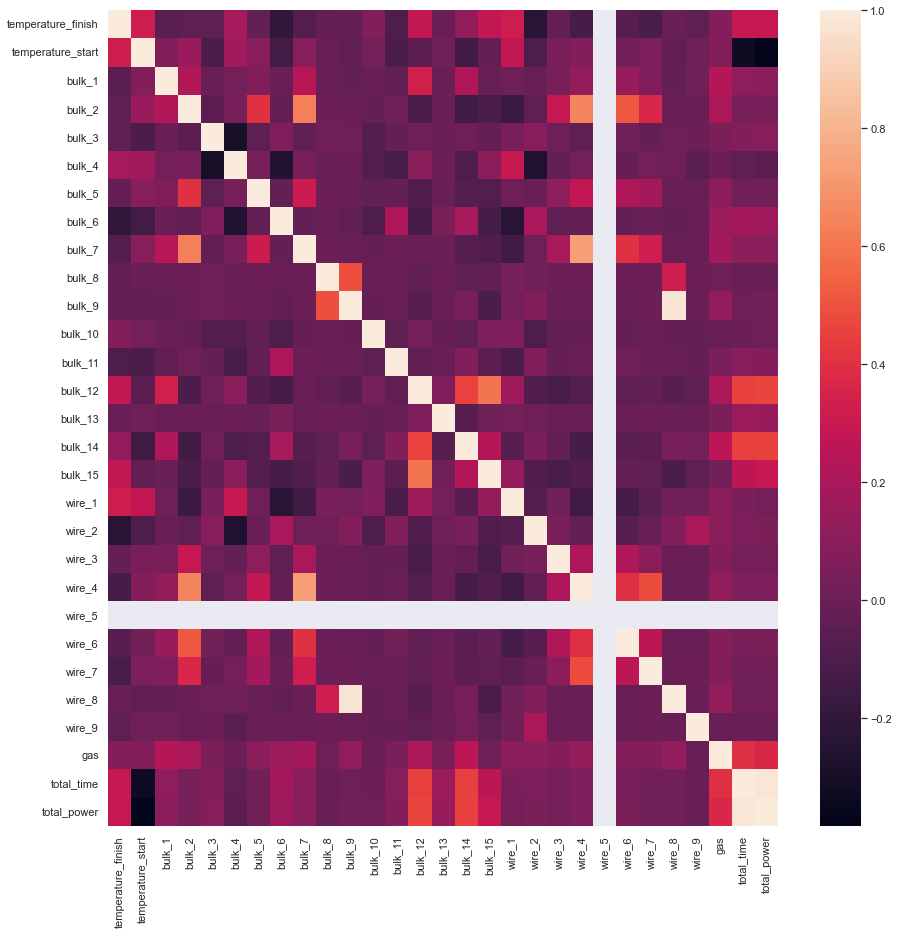

In [76]:
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(clear_data.drop('key', axis = 1).corr())

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Как видно на карте <b>wire_5</b> вообще не имеет значений после предобработки только 0, сильная корреляция между показателями <b>wire_8</b> и <b>bulk_9</b>, оставлю <b>bulk_9</b>. Так же, ожидаемый результат по сильной корреляции между <b>total_time</b> и <b>total_power</b>, оставлю из них <b>total_power</b>
</div>

In [77]:
# версия 2
final_data = clear_data.drop(['key', 'wire_5', 'wire_8', 'bulk_8', 'total_time'], axis = 1).reset_index(drop=True)

In [78]:
final_data.head()\
          .style\
          .set_caption(f'Сводные чистые данные')\
          .format('{:.0f}')\
          .set_table_styles(styler)

,temperature_finish,temperature_start,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas,total_power
0,1613,1571,0,0,0,43,0,0,0,0,0,0,206,0,150,154,60,0,0,0,0,0,0,30,6
1,1602,1581,0,0,0,73,0,0,0,0,0,0,206,0,149,154,96,0,0,0,0,0,0,13,4
2,1599,1596,0,0,0,34,0,0,0,0,0,0,205,0,152,153,91,0,0,0,0,0,0,29,3
3,1625,1601,0,0,0,81,0,0,0,0,0,0,207,0,153,154,89,0,0,0,0,0,0,19,4
4,1602,1576,0,0,0,78,0,0,0,0,0,0,203,0,151,152,89,9,0,0,0,0,0,5,4


<div style="background-color:gray; border:solid #363636 2px; padding: 20px">      
<span style="color:white"><b>Выводы:</b></span><br><br>
<span style="color:white">    
Данные были загружен и проанализированы, приведены в соответствие и очищены от выбросов, аномалий и пропусков. Необходимо отметить:<br>
<li>Качество предоставленных данных низкого качества;
<li>В данных много пропусков там, где их не должно быть;
<li>Существуют аномалии не в большом количестве, но возможно это мое непонимание технологического процесса;
<li>Большая проблема с временными тегами данных которые нарушают логику технологического процесса, либо опять я не до конца понимаю технологию производства;
<li>По-хорошему такие данные необходимо вернуть на доработку, возможно были допущены ошибки при выгрузке данных, или проконсультироваться с технологами по поводу корректности информации в этих датасетах;
<li>Данные готовы к подготовке и обучению модели.
</span>
</div>

## Подготовка модели

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
    
Основной задачей текущего проекта является прогноз температуры на основании фактических данных. Необходимо подготовить модель, которая способна с высокой долей вероятности прогнозировать конечную температур, что косвенно определяет затраченную  электроэнергию. Целевой признак в моей задаче количественный, который находится в признаках  <b><i>'temperature_finish'</i></b>, соответственно буду использовать модель для регрессии <b>DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, LGBMRegressor, Lasso, LinearRegression</b> в рамках предсказания, где целевой признак температура. Подбор параметров буду производить с помощью <b>GridSearchCV</b>. Выбор модели на основании метрики с предельно наименьшим значением <b>MAE</b>.
</div>

### Модели с базовыми параметрами

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
    
Перебирать все модели с параметрами я буду с помощью <b>GridSearchCV</b>, для этого подготовлю два списка с моделями <b><i>regressors</i></b> и с гиперпараметрами для этих моделей <b><i>parameters</i></b>. Для начала я решил проверить все модели на базовых гиперпараметрах, чтобы в дальнейшем можно было увидеть динамику изменения качества моделей, для оценки качества моделей выбираю 5 фолдов для кросс-валидации в настройках Grid
</div>

In [79]:
features = final_data.drop('temperature_finish', axis = 1)
target   = final_data['temperature_finish']

In [80]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size = 0.25, 
                                                                              random_state = RANDOM)

In [81]:
scaler = StandardScaler()
scaler.fit(features_train)    
features_train = scaler.transform(features_train)

In [82]:
regressors = [LinearRegression(),
              Lasso(random_state = RANDOM),
              DecisionTreeRegressor(random_state = RANDOM),
              ExtraTreesRegressor(random_state = RANDOM),
              RandomForestRegressor(random_state = RANDOM)]

In [83]:
parameters = [{}] * len(regressors)

In [84]:
%%time
scores = []

for i in notebook.tqdm(range(len(regressors))):
    
    grid_model = GridSearchCV(estimator  = regressors[i], 
                              param_grid = parameters[i],
                              scoring    = 'neg_mean_absolute_error',
                              n_jobs     = -1,
                              cv         = 5)
    
    grid_model.fit(features_train, target_train)        
    time_score    = grid_model.cv_results_['mean_test_score']   
    mean_fit_time = grid_model.cv_results_['mean_fit_time'][np.where(time_score == time_score.max())[0][0]]
    
    scores.append([' '.join(re.sub(r'([A-Z])', r' \1', str(regressors[i]).split('(')[0]).split()), 
                   grid_model.best_score_, 
                   mean_fit_time,
                   grid_model.best_params_])

  0%|          | 0/5 [00:00<?, ?it/s]

Wall time: 7.78 s


In [85]:
scores_base = scores

In [86]:
pd.DataFrame(data    = scores_base, 
             columns = ['model', 'mae', 'mean_fit_time', 'parameters'])\
            .sort_values('mae', ascending = False)\
            .reset_index(drop = True)\
            .style\
            .format({'mae':'{:.2f}', 'mean_fit_time' : '{:,.2f}s'})\
            .set_caption(f'Результаты моделей на базовых параметрах',)\
            .set_table_styles(styler)

,model,mae,mean_fit_time,parameters
0,Random Forest Regressor,-6.16,0.77s,{}
1,Linear Regression,-6.24,0.02s,{}
2,Extra Trees Regressor,-6.35,0.54s,{}
3,Lasso,-6.50,0.01s,{}
4,Decision Tree Regressor,-8.80,0.00s,{}


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Отличные результаты на базовых настройках показывают почти все модели, кроме <b>DecisionTreeRegressor</b>, метрика которой выходит за допустимые значения, лучшую метрику показывает <b>RandomForestRegressor</b>
</div>

### Подбор гиперпараметров

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
    
Далее буду перебрать параметры для моделей и на основании показателей качества моделей выберу лучшую
</div>

In [87]:
parameters = [{},
              
              {'selection'    : ['cyclic', 'random'],
               'max_iter'     : list(range(100,1000,100))}, 
              
              {'criterion'    : ['friedman_mse', 'poisson'],
               'max_depth'    : list(range(1,10))},
              
              {'n_estimators' : list(range(100,201,10)),
               'max_depth'    : list(range(10,21))},
              
              {'n_estimators' : list(range(100,201,10)),
               'max_depth'    : list(range(10,21))}]

In [88]:
%%time
scores = []

for i in notebook.tqdm(range(len(regressors))):
    
    grid_model = GridSearchCV(estimator  = regressors[i], 
                              param_grid = parameters[i],
                              scoring    = 'neg_mean_absolute_error',
                              n_jobs     = -1,
                              cv         = 3)
    
    grid_model.fit(features_train, target_train)        
    time_score    = grid_model.cv_results_['mean_test_score']   
    mean_fit_time = grid_model.cv_results_['mean_fit_time'][np.where(time_score == time_score.max())[0][0]]
    
    scores.append([' '.join(re.sub(r'([A-Z])', r' \1', str(regressors[i]).split('(')[0]).split()), 
                   grid_model.best_score_, 
                   mean_fit_time,
                   grid_model.best_params_])

  0%|          | 0/5 [00:00<?, ?it/s]

Wall time: 55.5 s


In [89]:
scores_param = scores

In [90]:
pd.DataFrame(data    = scores_param, 
             columns = ['model', 'mae', 'mean_fit_time', 'parameters'])\
            .sort_values('mae', ascending = False)\
            .reset_index(drop = True)\
            .style\
            .format({'mae':'{:.2f}', 'mean_fit_time' : '{:,.2f}s'})\
            .set_caption(f'Результаты поиска лучшей модели с подбором гиперпараметров',)\
            .set_table_styles(styler)

,model,mae,mean_fit_time,parameters
0,Random Forest Regressor,-6.12,0.96s,"{'max_depth': 16, 'n_estimators': 100}"
1,Extra Trees Regressor,-6.23,0.74s,"{'max_depth': 12, 'n_estimators': 150}"
2,Lasso,-6.52,0.02s,"{'max_iter': 100, 'selection': 'cyclic'}"
3,Decision Tree Regressor,-7.23,0.01s,"{'criterion': 'friedman_mse', 'max_depth': 4}"
4,Linear Regression,-11.17,0.01s,{}


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
При подборе гиперпараметров, модели так же показали отличный результат, немного улучшив показатели метрики, разница не такая большая как хотелось бы, на этом этапе результат с применением гиперпараметров моделей, лучшую метрику так же показывает <b>RandomForestRegressor</b>, правда уступая всем моделям по скорости работы алгоритма
</div>

### Модель LightGBM

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Отдельно подготовлю и обучу модель <b>LGBMRegressor</b>, после этого сделаю свод, проанализирую результаты и выберу модель
</div>

In [91]:
lgb_model = LGBMRegressor(random_state = RANDOM)

In [92]:
lgb_parameters = {
    'objective'        : ['regression'],
    'metric'           : ['neg_mean_absolute_error'],
    'boosting_type'    : ['gbdt'],
    'num_leaves'       : [10,20,30],
    'learning_rate'    : [0.01],
    'max_depth'        : [5,10,15],
    'n_estimators'     : [5,10,15],
    'num_iterations'   : [500],
    'min_child_samples': [20,30,40]
                 }

In [93]:
%%time
scores = []

grid_model = GridSearchCV(estimator  = lgb_model,
                          param_grid = lgb_parameters,
                          scoring    = 'neg_mean_absolute_error',
                          verbose    = 10,
                          n_jobs     = -1,
                          cv         = 3)
                          
grid_model.fit(features_train, target_train)

time_score    = grid_model.cv_results_['mean_test_score']
mean_fit_time = grid_model.cv_results_['mean_fit_time'][np.where(time_score == time_score.max())[0][0]]

scores.append(['LGBM Regressor',
               grid_model.best_score_,
               mean_fit_time,
               grid_model.best_params_])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Wall time: 10.4 s


In [94]:
scores_lgb = scores

In [95]:
pd.DataFrame(data    = scores_lgb, 
             columns = ['model', 'mae', 'mean_fit_time', 'parameters'])\
            .sort_values('mae', ascending = False)\
            .style\
            .format({'mae':'{:.2f}', 'mean_fit_time' : '{:,.2f}s'})\
            .set_caption(f'Результаты поиска лучшей модели LightGBM с подбором гиперпараметров',)\
            .set_table_styles(styler)

,model,mae,mean_fit_time,parameters
0,LGBM Regressor,-6.03,0.58s,"{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 10, 'metric': 'neg_mean_absolute_error', 'min_child_samples': 30, 'n_estimators': 5, 'num_iterations': 500, 'num_leaves': 20, 'objective': 'regression'}"


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Модель <b>LGBMRegressor</b> показала лучший результат по качеству модели, не уступая сильно моделям по скорости работы алгоритма. Посмотрим на результаты всех этапов, сделаем выводы и выберем лучшую модель для тестирования
</div>

In [96]:
data_info = pd.DataFrame(data = np.array(scores_base)[:,:3], 
                          columns = ['model', 'mae_base', 'time_base']) \
                                                                         \
                                .append(pd.DataFrame(data = np.array(scores_lgb)[:,:3],
                                                     columns = ['model', 'mae_base', 'time_base'])) \
                                                                                                     \
                                .merge(pd.DataFrame( data = np.array(scores_param)[:,:3], 
                                                     columns = ['model', 'mae_param', 'time_param']) \
                                                                                                      \
                                                .append(pd.DataFrame(data = np.array(scores_lgb)[:,:3], 
                                                     columns = ['model', 'mae_param', 'time_param'])), 
                                                                   on = 'model', 
                                                                   how = 'outer')

data_info.loc[5][['mae_base', 'time_base']] = 0

In [97]:
data_info.sort_values(['mae_param', 'time_param'], ascending = [False, True]).reset_index(drop = True) \
                                .style\
                                .format({'mae_base':'{:.2f}', 
                                         'time_base' : '{:,.2f}s',
                                         'mae_param':'{:.2f}', 
                                         'time_param' : '{:,.2f}s'})\
                                .set_caption(f'Результаты этапов обучения моделей',)\
                                .set_table_styles(styler)

,model,mae_base,time_base,mae_param,time_param
0,LGBM Regressor,0.00,0.00s,-6.03,0.58s
1,Random Forest Regressor,-6.16,0.77s,-6.12,0.96s
2,Extra Trees Regressor,-6.35,0.54s,-6.23,0.74s
3,Lasso,-6.50,0.01s,-6.52,0.02s
4,Decision Tree Regressor,-8.80,0.00s,-7.23,0.01s
5,Linear Regression,-6.24,0.02s,-11.17,0.01s


<div style="background-color:gray; border:solid #363636 2px; padding: 20px">    
<span style="color:white"><b>Выводы:</b></span><br>   
<span style="color:white">
Как видно из сводных данных выше, лучшие показатели по качеству предсказания показывает модель <b>LGBMRegressor</b>. На данном этапе мы определяем лучшую модель по критериям время/качество. Модель <b>Random Forest Classifier</b>, демонстрирует схожие результаты по качеству моделирования, ее я тоже перенесу на следующий этап, но ужен не в качестве выбранной модели а для чтобы посмотреть как она ведет себя на тестовых данных, так как данная модель показала результаты почти аналогичные выбранной модели.
</span>
</div>

## Тестирование лучшей модели

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Тестирование модели буду проводить на тестовой выборке для выбранной модели на предыдущем этапе
</div>

In [98]:
features_test = scaler.transform(features_test)

### Тестирование модели Random Forest Regressor (вне проекта)

In [99]:
final_model_RF = RandomForestRegressor(**scores_param[4][3])

In [100]:
%%time
start = time()        
final_model_RF.fit(features_train, target_train)     
train_time_RF = time() - start 

Wall time: 1.06 s


In [101]:
final_pred_RF  = final_model_RF.predict(features_test)
final_score_RF = mean_absolute_error(target_test, final_pred_RF)

In [102]:
print(f'Показатели MAE на тестовой выборке = {final_score_RF:.2}')

Показатели MAE на тестовой выборке = 6.2


### Тестирование модели LGBM Regressor

In [103]:
final_model_LGB = LGBMRegressor(**scores_lgb[0][3])

In [104]:
%%time
start = time()        
final_model_LGB.fit(features_train, target_train)     
train_time_LGB = time() - start 

Wall time: 419 ms


In [105]:
final_pred_LGB  = final_model_LGB.predict(features_test)
final_score_LGB = mean_absolute_error(target_test, final_pred_LGB)

In [106]:
print(f'Показатели MAE на тестовой выборке = {final_score_LGB:.2}')

Показатели MAE на тестовой выборке = 6.1


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
И так все этапы пройдены, необходимо посмотреть на результаты всех расчетов
</div>

In [107]:
final_scores = [['Random Forest Regressor', -final_score_RF, train_time_RF],
                ['LGBM Regressor', -final_score_LGB, train_time_LGB,]]

In [108]:
data_info \
    .merge(pd.DataFrame(final_scores, columns = ['model', 'mae_final', 'time_final']),
                           on = 'model', how = 'outer') \
                            .sort_values(['mae_final', 'time_final'], ascending = [False, True]).reset_index(drop = True) \
                            .fillna(0).style\
                            .format({'mae_base'  : '{:.2f}', 
                                     'time_base'  : '{:,.2f}s',
                                     'mae_param' : '{:.2f}', 
                                     'time_param' : '{:,.2f}s',
                                     'mae_final' : '{:.2f}',
                                     'time_final' : '{:.2f}s'})\
                            .set_caption(f'Финальные результаты обучения моделей',)\
                            .set_table_styles(styler)

,model,mae_base,time_base,mae_param,time_param,mae_final,time_final
0,LGBM Regressor,0.00,0.00s,-6.03,0.58s,-6.08,0.42s
1,Random Forest Regressor,-6.16,0.77s,-6.12,0.96s,-6.22,1.06s
2,Linear Regression,-6.24,0.02s,-11.17,0.01s,0.00,0.00s
3,Lasso,-6.50,0.01s,-6.52,0.02s,0.00,0.00s
4,Decision Tree Regressor,-8.80,0.00s,-7.23,0.01s,0.00,0.00s
5,Extra Trees Regressor,-6.35,0.54s,-6.23,0.74s,0.00,0.00s


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
В сводной таблице представлены данные за все пройденные этапы, как уже было сказано ранее была выбрана модель <b>LGBM Regressor</b>, как основное решение, которая показала отличный результат на тестовой выборке, модель имеет качество метрики <b>MAE 6,08</b>, задание по подготовке модели выполнено. На тестовой выборке модель <b>Random Forest Regressor</b> модель просела по качеству предсказания значительнее чем основная модель. Далее хотелось бы визуально представить результаты предсказания модели и оценить ее качественные характеристики.<br><br>
Ниже представлена информация, какие признаки внесли больший вклад в обучении модели, здесь можно уже говорить о том что возможно стоило очистить данные в большей степени, Основными фичами оказались общая затраченная энергия и температура на старте,
</div>

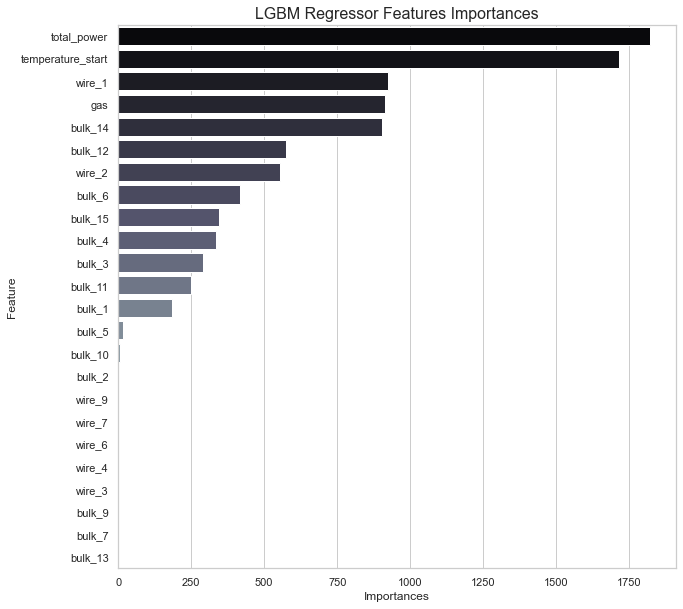

In [109]:
feature_importances = pd.DataFrame(sorted(zip(final_model_LGB.feature_importances_, features.columns)), 
                                   columns = ['Importances','Feature'])

plt.figure(figsize = (10, 10))
sns.set_style('whitegrid')
sns.barplot(x = 'Importances', 
            y = 'Feature', 
            data = feature_importances.sort_values(by = 'Importances', ascending = False),
            palette = 'bone')
plt.title('LGBM Regressor Features Importances', fontsize = 16)
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">     
Как и было описано ранее в плане работы, я хотел провести несколько итераций подготовки и обучения моделей, чтобы можно было увидеть качественное изменение метрики в рамках данного проекта. Как видно, модели с самого начала начали справляться с поставленной задачей, но необходимо было улучшить показатели, для стабильности результата на тестовой выборке, для этого были подобраны и применены гиперпараметры моделей для поиска лучшего результата, что в конечном итоге повлияло на отличный результат в финале. На тестовом наборе модели показали результат ниже чем на тренировочном наборе, но эти изменения минимальны, результат стабильный и демонстрирует, что модель хорошо обучилась и разбирается в данных (не переобучена и не до обучена). Соответственно можно сделать выводы, что на стадии предобработки и очистки данных были сделаны корректные изменения
</div>

### Сравнение распределения предсказаний моделей

In [110]:
# Подготовлю данные в табличном виде для визуализации
data_info = pd.DataFrame(np.array(final_pred_LGB)) \
                    .assign(model = 'LGBM Regressor', sample = 'predict') \
                    .append(pd.DataFrame(np.array(target_test)).assign(model = 'LGBM Regressor', sample = 'true'))

data_info = data_info.append(pd.DataFrame(np.array(final_pred_RF)) \
                    .assign(model = 'Random Forest Regressor', sample = 'predict') \
                    .append(pd.DataFrame(np.array(target_test)).assign(model = 'Random Forest Regressor', sample = 'true'))) \
                    .rename(columns = {0: 'values'})

In [111]:
# Проверка на корректную сборку таблицы
target_test.shape[0] * 4 - data_info.shape[0]

0

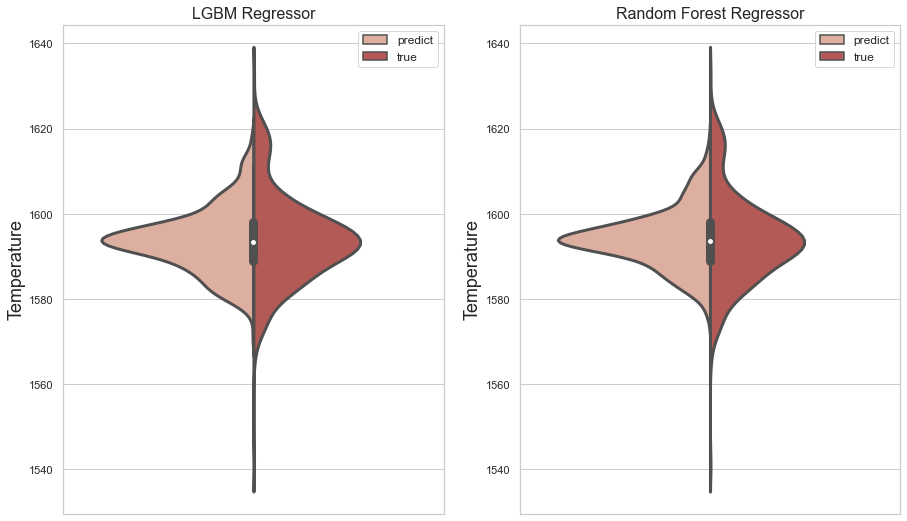

In [112]:
plt.figure(figsize=(15, 9))
sns.set_style('whitegrid')

for i, model in enumerate(data_info['model'].unique()):
    
    plt.subplot(1, 2, i + 1)   
    sns.violinplot(x = 'model', 
                   y = 'values', 
                   hue = 'sample',
                   data = data_info[data_info['model'] == model],
                   palette    = 'Reds',
                   saturation = 0.5, 
                   linewidth  = 3,
                   edgecolor  = '#444444',
                   split = True)
    
    plt.title(f'{model}', fontsize = 16);
    plt.ylabel('Temperature', fontsize = 18)
    plt.xlabel('')
    plt.xticks(range(1),[''])
    plt.legend(fontsize = 12)
    
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
На графике видны качества предсказания этих моделей, модели <b>LGBM Regressor</b> и <b>Decision Tree Regressor</b> имеют схожие распределения предсказаний. Но все равно не дотягивают до целевого признака, распределение сильно усредняет значения предсказания, особенно плохо модель работает с верхним и нижнем уровнем температуры, я могу это связать с тем что в целевом наборе, данных для этих диапазонов не достаточно для нормально обучения модели, соответственно не достаточно обучена на этих уровнях. Далее я хотел бы проверить эти показатели на адекватность, для того чтобы убедиться не сильно ли модели усредняют данные по моделированию.
</div>

### Проверка на адекватность

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Окончательно проверю модель на адекватность с помощю <b>DummyRegressor</b>
</div>

In [113]:
dummy_model  = DummyRegressor()

dummy_model.fit(features_train, target_train) 

dummy_pred   = dummy_model.predict(features_test)

dummy_result = mean_absolute_error(target_test, dummy_pred)

print(f'показатель MAE на модели DummyRegressor: {dummy_result:.2f}')

показатель MAE на модели DummyRegressor: 7.82


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Показатель MAE на модели <b>Dummy Regressor = 7,82</b> это хуже чем на модели <b>LGBM Regressor</b> на 29%, отклонения значительные но не критичные, тем более что даже эта модель уложилась в диапазон требуемого качества, возможно это связано со спецификой самого датасета и температурного диапазона технологического процесса
</div>

## Выводы

<div style="background-color:#424B54; border:solid #373d43 2px; padding: 20px">    
<span style="color:#EBEBEB"><b>Выводы:</b></span><br><br>   
<span style="color:#EBEBEB">
Перед началом работ была описана проблематика работы и поставлена задача, чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого необходимо построить модель, которая предскажет температуру стали. Так же заказчик озвучил требуемые характеристики качества модели со значением метрики качества <b>MAE</b> не более <b>8.7</b>.<br><br>
<li>Предоставленные данные были проанализированы. В наборах данных было обнаружено большое количество артефактов в виде выбросов и аномальных значений, так же присутствовали проблемы, при анализе которых выявлены нарушения технологического процесса, что явно говорит о нарушении выгрузки данных. Данные по-хорошему необходимо отправить на проверку и повторную выгрузку;
<li>Прим моделировании стояла задача регрессии, для этого необходимо было подготовить несколько моделей регрессии. Для этого проекта были выбраны LinearRegression, Lasso, DecisionTreeRegressor, ExtraTreesRegressor, RandomForestRegressor, LGBM Regressor;
<li>Далее последовательно в были обучены и проверены модели, из которой бала выбрана модель с лучшими показателями метрики качества;
<li>На тестовых данных модель показала требуемый результат, и стабильную работу на незнакомых данных, что подтвердило ее высокое качество метрики <b>MAE 6.08</b>;
<li>Задача по подготовке модели была выполнена.<br><br>
<span style="color:#EBEBEB"><b>Итог выбора:</b></span><br><br>    
Лучшая модель LGBM Regressor с параметрами:<br>
<li>boosting_type: 'gbdt',    
<li>learning_rate: 0.01,    
<li>max_depth: 10,    
<li>metric: 'neg_mean_absolute_error',    
<li>min_child_samples: 30,    
<li>n_estimators: 5,    
<li>num_iterations: 500,    
<li>num_leaves: 20,    
<li>objective: 'regression'    
</span>
</div>